# 1 - Sources des données

## Données tabulaires - SAE

## Web Scrapping - Doctolib

Pour avoir un **indice de la disponibilité des IVGs en France**, nous allons utiliser des données issues du site de prise de rendez-vous médicales le plus utilisé en France, **Doctolib**. Par département et spécialisation IVG, les données extraites sont le nombre de localisations différentes proposant un RDV IVG dans un délai de 14, 30 et 90 jours. Ces données sont accessibles à tous gratuitement en utilisant leur moteur de recherche et des filtres (par [ex](https://www.doctolib.fr/ivg-medicamenteuse/paris?availabilitiesBefore=90&regulationSector%5B%5D=CONTRACTED_1&regulationSector%5B%5D=CONTRACTED_1_WITH_EXTRA&regulationSector%5B%5D=CONTRACTED_1_WITH_OPTAM&regulationSector%5B%5D=CONTRACTED_1_WITH_OPTAM_CO&regulationSector%5B%5D=CONTRACTED_2&regulationSector%5B%5D=CONTRACTED_2_WITH_OPTAM&regulationSector%5B%5D=CONTRACTED_2_WITH_OPTAM_CO&regulationSector%5B%5D=CONTRACTED&regulationSector%5B%5D=CONTRACTED_WITH_EXTRA&regulationSector%5B%5D=ORGANIZATION_CONTRACTED)).

Pour la mise en oeuvre, le script est `scrapper_doctolib.py` qui crée un .csv à l'aboutissement. Le script s'appuie sur la librairie `Playwright` permet de faire du web scrapping sur des sites dynamiques (comme Doctolib qui utilise react et javascript) en utilisant des navigateurs "headless" dans l'arrière plan. Avant de finir sur cette librairie, d'autres options ont été tentées : `BeautifulSoup` (pour adapté au parsing des sites statiques) et `Selenium` (une autre librairie de "headless browsers"). Cependant, `Playwright` a était le plus agile pour la gestion du chargement de la page. De plus, `asyncio` est utilisé pour faire du parallélisme et réduire le temps de scrapping.

> Point législatif
> 
> [Source (CNIL) : ](https://www.cnil.fr/fr/focus-interet-legitime-collecte-par-moissonnage)

Exemple des données obtenues (format dataframe pandas) suite au scraping (environ une demi-heure) :

In [1]:
from scripts.compilation_donnees import *

In [2]:
def importer_tout():
    df_SAE = importer_SAE()
    df_dep = importer_departement()
    df_finess = importer_finess()
    df_drees = importer_drees()
    df_pauv = importer_pauv()

    return df_SAE, df_dep, df_finess, df_drees, df_pauv

def importer_locale(date):
    folder = './donnees/'
    suffix = '_' + date + ".csv"

    df_SAE = pd.read_csv(folder + "SAE" + suffix)
    df_dep = pd.read_csv(folder + "dep" + suffix)
    df_finess = pd.read_csv(folder + "finees" + suffix)
    df_drees = pd.read_csv(folder + "drees" + suffix)
    df_pauv = pd.read_csv(folder + "pauv" + suffix)

    return df_SAE, df_dep, df_finess, df_drees, df_pauv

def sauvegarde_locale():
    df_SAE, df_dep, df_finess, df_drees, df_pauv = importer_tout()
    df_SAE.to_csv(get_path("SAE"), index=False)
    df_dep.to_csv(get_path("dep"), index=False)
    df_finess.to_csv(get_path("finees"), index=False)
    df_drees.to_csv(get_path("drees"), index=False)
    df_pauv.to_csv(get_path("pauv"), index=False)

    return 1

In [3]:
df_SAE, df_dep, df_finess, df_drees, df_pauv = importer_locale("2025-12-12-10-24")

# 2 - Statistiques descriptives 


In [4]:
df_nbcentre = pd.crosstab(df_finess["14"], df_finess["19"])

# df_nbcentre.rename(columns={"14": "Département"}, inplace=True)
df_nbcentre.index.name = "Département"
df_nbcentre = df_nbcentre[["Centre de santÃ© sexuelle", "Centre gratuit d'information de dÃ©pistage et de diagnostic"]]
df_nbcentre.rename(columns={
    'Centre de santÃ© sexuelle': 'Centre de sante sexuelle', 
    "Centre gratuit d'information de dÃ©pistage et de diagnostic" : 'CeGIDD'}, inplace=True)
print(df_nbcentre.head(5))

# à normaliser par nombre d'habitant, pour 1000 habitant (pr avoir un chiffre interprétable)


#Centre de santÃ© sexuelle
#Centre gratuit d'information de dÃ©pistage et de diagnostic

19                       Centre de sante sexuelle  CeGIDD
Département                                              
AIN                                             1       2
AISNE                                           5       3
ALLIER                                          3       3
ALPES DE HAUTE PROVENCE                         0       0
ALPES MARITIMES                                 8       1


In [5]:
# faire la moyenne des délais dans la SAE + nombre de centre qui font des IVG par département 
df_SAE.head(5)
#moy_delais = df_SAE.groupby(dep)[‘Valeur'].mean().reset_index()
# nb centre qui prend en charge les IVG par département 
df_prise_en_charge_dep = (
    df_SAE
    .groupby('dep')['PRIS']
    .sum()
    .reset_index()
)
df_prise_en_charge_dep.head(5)
df_prise_en_charge_dep.rename(columns={'dep': 'DEP'}, inplace=True)
df_dep_ivg = pd.merge(df_prise_en_charge_dep, df_dep, on=['DEP'], how='outer')

df_dep_ivg['Département'] = (
    df_dep_ivg['Département']
        .str.replace('-', ' ', regex=False)
        .str.upper()
)



In [6]:
df_dep_ivg = pd.merge(df_dep_ivg, df_nbcentre, on=['Département'], how='outer')
df_dep_ivg.head(5)


,DEP,PRIS,REG,Région,Département,PMUN,Centre de sante sexuelle,CeGIDD
0,01,4.0,84.0,Auvergne-Rhône-Alpes,AIN,663202.0,1.0,2.0
1,02,5.0,32.0,Hauts-de-France,AISNE,527468.0,5.0,3.0
2,03,4.0,84.0,Auvergne-Rhône-Alpes,ALLIER,334872.0,3.0,3.0
3,04,2.0,93.0,Provence-Alpes-Côte d'Azur,ALPES DE HAUTE PROVENCE,166077.0,0.0,0.0
4,06,10.0,93.0,Provence-Alpes-Côte d'Azur,ALPES MARITIMES,1103941.0,8.0,1.0


In [7]:
df_dep_ivg["pop_fe"] = df_dep_ivg["PMUN"] / 2 # population par département divisée par deux pour approximer le nombre de femmes
df_dep_ivg["PRIS_pour1000fe"] = (df_dep_ivg["PRIS"] / df_dep_ivg["pop_fe"])*100000 # nombre de centre qui prennent en charge des IVG pour 1000 femmes
df_dep_ivg["nb_centre_pour1000fe"] = (df_dep_ivg["Centre de sante sexuelle"] / df_dep_ivg["pop_fe"])*100000
df_dep_ivg["nb_cegidd_pour1000fe"] = (df_dep_ivg["CeGIDD"] / df_dep_ivg["pop_fe"])*100000
df_dep_ivg["centres_total"] = df_dep_ivg["Centre de sante sexuelle"] + df_dep_ivg["CeGIDD"]
df_dep_ivg["centres_total_pour1000fe"] = (df_dep_ivg["centres_total"] / df_dep_ivg["pop_fe"])*100000
valeur_min = df_dep_ivg["pop_fe"].min()
print(valeur_min) # 38259 < 100 000 : donc on conserve pr avoir un chiffre interprétable mais pas réaliste pr certains départements


38259.5


Travail sur les données DREES pour réaliser des évolutions dans le temps au niveau national : juste présenter les données comme y'a déjà publier sur la DREES 

,zone_geo,IVG_HOSP_INS,IVG_HOSP_MED,IVG_HOSP_INC,IVG_CAB,IVG_CEN,TOT_IVG,TAUX_rec,annee,IVG_INST,...,AGE_20_24,AGE_25_29,AGE_30_34,AGE_35_39,AGE_40&plus,IVG_GO,IVG_MG,IVG_SF,IVG_AUT,Unnamed: 6
0,Ain,449.0,857.0,5.0,184.0,11.0,1506.0,"10,81725589",2016.0,214.0,...,346.0,331.0,333.0,225.0,124.0,0,77,0,0,NaN
1,Ain,362.0,831.0,7.0,264.0,11.0,1475.0,"10,57810225",2017.0,149.0,...,331.0,339.0,307.0,242.0,99.0,0,150,0,0,NaN
2,Ain,395.0,766.0,3.0,366.0,11.0,1541.0,"11,06380535",2018.0,154.0,...,370.0,357.0,315.0,249.0,112.0,NC,202,0,0,NaN
3,Ain,410.0,855.0,17.0,342.0,11.0,1635.0,"11,72681891",2019.0,172.0,...,377.0,376.0,337.0,269.0,125.0,0,177,13,0,NaN
4,Ain,323.0,792.0,8.0,436.0,16.0,1575.0,"11,29461372",2020.0,179.0,...,311.0,319.0,379.0,286.0,136.0,0,192,117,NC,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


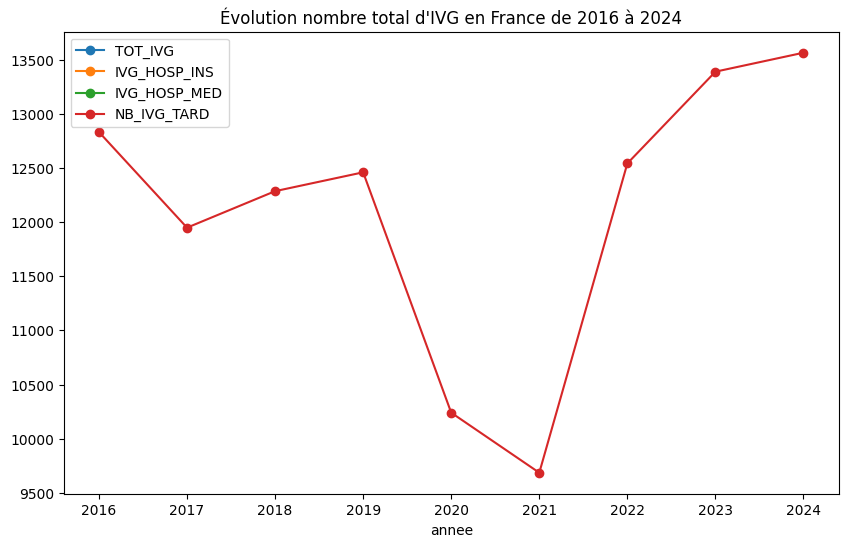

In [10]:
df_drees_filtre = df_drees[df_drees["zone_geo"] == "France entière"]
df_drees_filtre.plot(x="annee", y=["TOT_IVG", "IVG_HOSP_INS", "IVG_HOSP_MED", "NB_IVG_TARD"], kind="line", marker='o', figsize=(10,6), title="Évolution nombre total d'IVG en France de 2016 à 2024")

df_drees

In [11]:
# faire un graph avec plusieurs courbes 
df_drees_filtre.set_index("annee")[["TOT_IVG", "IVG_HOSP_INS"]].plot(
    kind="line",
    marker='o',
    figsize=(10,6),
    title=f"Évolution de Truc A et Truc B pour la zone {Total IVG realisees en France}"
)



SyntaxError: invalid syntax. Perhaps you forgot a comma? (528162136.py, line 6)